In [77]:
import pandas as pd
import numpy as np
import backtrader as bt
import datetime
import sys
import quandl
import matplotlib.pyplot as plt
import requests
import yfinance
import statsmodels.tsa.stattools as ts
#plt.style.use('dark_background')

In [2]:
class MyStrategy(bt.Strategy):
    params = (
        ('sma_period', 14),
    )
    
    def __init__(self):
        # Keep reference to close price
        self.dataclose = self.datas[0].close
        # Keep track of pending orders
        self.order = None
        # Add commission
        self.buyprice = None
        self.buycomm = None
        
        # Simple moving average indicator
        self.sma = bt.indicators.SimpleMovingAverage(
            self.datas[0], period=self.params.sma_period
        )
    
    def log(self, txt, dt=None):
        '''Utility function to output log'''
        dt = dt or self.datas[0].datetime.date(0)
        print(f"{dt.isoformat()}, {txt}")

    def notify_order(self, order):
        '''Keep track of status of an order'''
        if order.status in [order.Submitted, order.Accepted]:
            return

        if order.status == order.Completed:
            if order.isbuy():
                self.log(
                    f"BUY EXECUTED at Price: {order.executed.price}, "
                    f"Cost: {order.executed.value}, "
                    f"Commission: {order.executed.comm}"
                )
                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm

            elif order.issell():
                self.log(
                    f"SELL EXECUTED at Price: {order.executed.price}, "
                    f"Cost: {order.executed.value}, "
                    f"Commission: {order.executed.comm}"
                )

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log("Order Cancelled/Margin/Rejected")
        
        # No pending order left
        self.order = None
    
    def notify_trade(self, trade):
        if not trade.isclosed:
            return
        self.log(f"OPERATION PROFIT, GROSS: {trade.pnl}, NET: {trade.pnlcomm}")

    def next(self,):
        self.log(f'Close, {self.dataclose[0]}')

        # If an order is already pending, cannot send another one
        if self.order:
            return 
        
        # Check if in the market
        if not self.position:
            # Strategy: if closing price higher than SMA, buy; else sell
            if self.dataclose[0] > self.sma[0]:
                self.log(f'BUY CREATE {self.dataclose[0]}')
                # keep track of created order
                self.order = self.buy()
        else:
            # Already in the market, maybe sell now
            if self.dataclose[0] < self.sma[0]:
                self.log(f"SELL CREATE {self.dataclose[0]}")

                self.order = self.sell()


In [114]:
# Get data
# Quandl
#symbol = "AAPL"
#bars = quandl.get(
#    f"WIKI/{symbol}", api_key=quandl_api, 
#    start_date='2012-1-1', end_date='2012-12-31',
#    collapse='daily',
#)
# Yahoo finance
# try top 20 market cap coins (~ > $1B)
tickers = [
    "BTC-USD", "ETH-USD", "USDT-USD", "XRP-USD", "BCH-USD", "LINK-USD", 
    "BNB-USD", "LTC-USD", "ADA-USD", 
    "EOS-USD", "XMR-USD", "TRX-USD", "XLM-USD", 
    "NEO-USD",
    # not available on yfinance
    #"DOT-USD", "BSV-USD", "USDC-USD", "CRO-USD", "WBTC-USD", "XTZ-USD", 
]
bars = yfinance.download(tickers, start="2018-01-01", end="2020-10-22", nthreads=6)

[*********************100%***********************]  14 of 14 completed


In [110]:
bars.rename(columns=
    {
        'Adj Open': 'open', 'Adj High': 'high', 'Adj Low': 'low', 'Adj Close': 'close',
        'Volume': 'volume', 
    },
    inplace=True
)

[*********************100%***********************]  14 of 14 completed


In [111]:
data = bt.feeds.PandasData(dataname=bars)

In [112]:
# Create Cerebro instance
cerebro = bt.Cerebro()

# Add the strategy 
cerebro.addstrategy(MyStrategy)

# Add the DataFeed
cerebro.adddata(data)

# Starting cash
cerebro.broker.setcash(100000.)

# Add FixedSize sizer 
cerebro.addsizer(bt.sizers.FixedSize, stake=10)

# Add 0.1% commission fees
cerebro.broker.setcommission(commission=0.001)

In [113]:
# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 100000.00


AttributeError: 'tuple' object has no attribute 'lower'

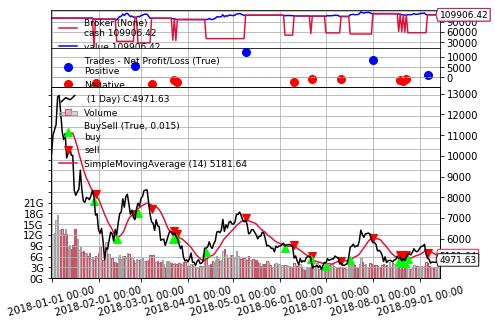

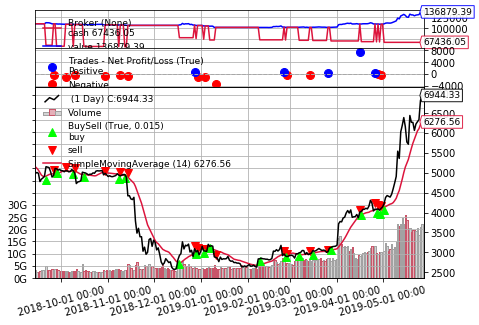

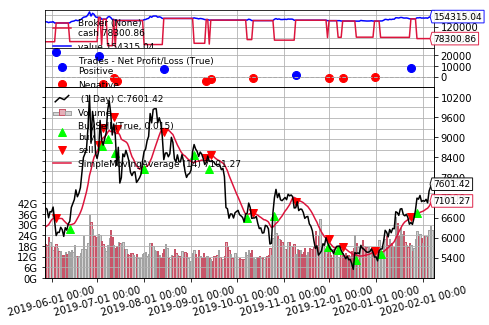

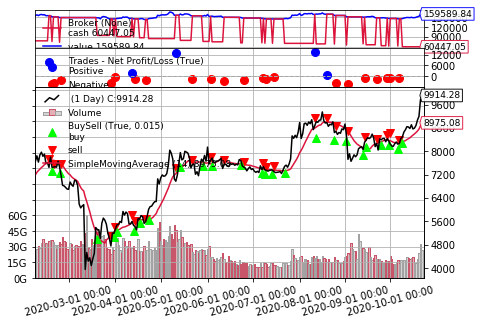

In [108]:
result = cerebro.plot(numfigs=4, iplot=False, use='agg')

In [1]:
def send_telegram_message(message=""):
    base_url = f"https://api.telegram.org/bot{bot_api}"
    return requests.get(f"{base_url}/sendMessage", params={
        'chat_id': chat_id,
        'text': message, 
    })

In [19]:
send_telegram_message("ciao")

<Response [200]>

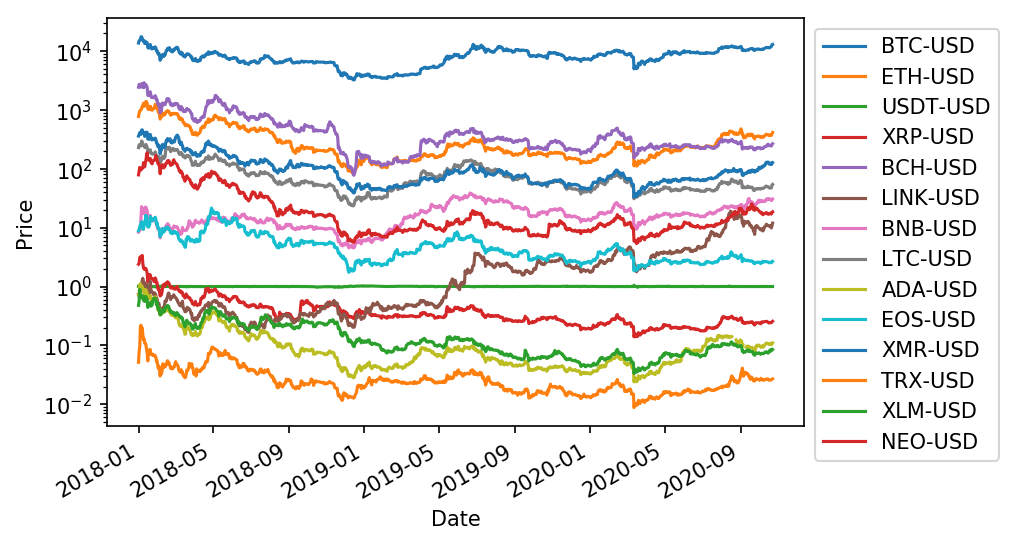

In [118]:
fig, ax = plt.subplots(dpi=150)
for ticker in tickers:
    ax = bars["Adj Close"][ticker].plot()
ax.set_yscale('log')
ax.set_ylabel('Price')
ax.legend(bbox_to_anchor=(1,1))

In [135]:
def test_cointegration(data, ticker1, ticker2,):
    # Need to dropna() in case we are using stocks and not forex/crypto
    # which run only on weekdays
    test_coint = pd.merge(
        data["Adj Close"][ticker1], data["Adj Close"][ticker2], on="Date"
    ).dropna()
    x = test_coint[ticker1]
    y = test_coint[ticker2]
    coint_result = ts.coint(x, y)
    #print(f"p-value of cointegration: {coint_result[1]}")
    return coint_result

In [136]:
coint_results = np.empty((len(tickers), len(tickers)), dtype=float)
for idx, first in enumerate(tickers):
    for jdx, second in enumerate(tickers):
        if first != second:
            coint_results[idx, jdx] = test_cointegration(bars, first, second)[1]